In [1]:
import os

import numpy as np
import pandas as pd
import torch
import tqdm.autonotebook as tqdm
import matplotlib.pyplot as plt
from src.commons.visualizations import gradcam, h_stack_imgs


from settings.config import EXPERIMENTS_PATH
from src.lightning.lgn_models import BaseLGNM
from src.commons.exp_config import ExpConfig
from src.training._commons import set_torch_constants, load_datamodule
from src.data_processing.data_handling import LightImagesRecipesDataset
from src.commons.utils import pred_digits_to_values
from torchmetrics import Accuracy, ConfusionMatrix

set_torch_constants()

C:\Users\polil\AppData\Local\Temp\ipykernel_20892\2015141033.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
exp_dir = os.path.join(EXPERIMENTS_PATH, 'dummy', 'dummy_experiment')
ckpt_path = os.path.join(exp_dir, 'trial_1', 'best_model.ckpt')
exp_config = ExpConfig.load_from_ckpt_data(torch.load(ckpt_path))
exp_config.trainer

FileNotFoundError: [Errno 2] No such file or directory: 'H:\\programmazione\\python_projects\\ingredient_recognition\\experiments\\dummy\\dummy_experiment\\trial_1\\best_model.ckpt'

In [33]:
from torchvision.models import resnet18, ResNet18_Weights

weights=ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet.input_shape = exp_config.datamodule['image_shape']
resnet.num_classes = exp_config.hp['num_classes']

In [12]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
trainer = exp_config.trainer['type'].load_from_config(exp_config.trainer)
data_module = load_datamodule(exp_config)
model = exp_config.lgn_model['lgn_model_type'].load_from_config(exp_config.lgn_model).to('cuda')
model.load_weights_from_checkpoint(ckpt_path)
model = model.model

In [14]:
batch = next(iter(data_module.val_dataloader()))
X, y = batch

In [15]:
model.block_3.block

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
target_layer = model.block_3.block[-3]

In [29]:
target_layer

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [30]:
imgs_plot, gradcam_masks, targets, outputs = gradcam(model, target_layer, X)

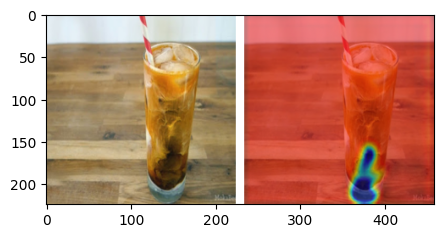

In [31]:
img_index = 53
plt.imshow(h_stack_imgs(X[img_index].numpy(), imgs_plot[img_index]))

In [ ]:
data_module.label_encoder.inverse_transform(pred_digits_to_values(outputs))

array([['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil', 'pepper', 'salt'],
       ['oil',

In [ ]:
lb = data_module.label_encoder
lb.decode_labels([142])

array([['salt']], dtype=object)

In [41]:
target_layer = resnet.layer4[-1]

imgs_plot, gradcam_masks, targets = gradcam(resnet, target_layer, X, img_weight=0.3)[:-1]

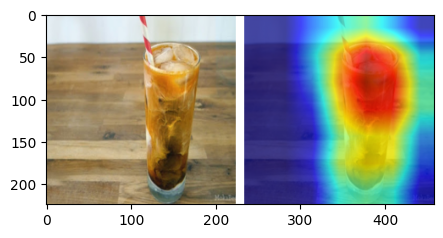

In [42]:
plt.imshow(h_stack_imgs(X[img_index].numpy(), imgs_plot[img_index]))

In [ ]:
import plotly.express as px

px.imshow(gradcam_masks[img_index]).add_annotation(x=0.7, y=0.3, text='sale', showarrow=False, xref='paper', yref='paper')

In [ ]:
targets

array([551, 959, 925, 925, 910, 809, 861, 861, 868, 591, 925, 551, 928,
       999, 680, 712, 617, 959, 909, 935, 925, 945, 921, 591, 118, 794,
       964, 959, 746, 961, 868, 591, 584, 925, 961, 969, 961, 669, 959,
       712, 551, 959, 868, 551, 961, 868, 969, 928, 470, 924, 109, 961,
       125, 438, 666, 809, 923, 809, 925, 935, 700, 998, 961, 921, 925,
       470, 329, 739, 868, 925, 961, 551, 938, 738, 925, 925, 964, 961,
       961, 925, 935, 925, 117, 924, 943, 455, 933, 910, 964, 925, 925,
       923, 551, 928, 861, 925, 938, 923, 861,  36, 551, 793, 961, 959,
       964, 969, 910, 961, 969, 516, 964, 935, 551, 927, 431, 935, 126,
       938,  69, 961, 861, 712, 804, 925, 964, 647, 925, 965], dtype=int64)

In [ ]:

dataset = data_module.val_dataloader().dataset.to_light_dataset(data_module.label_encoder)



In [ ]:
import pandas as pd
pd.DataFrame(dataset.label_data).explode(column='label')

KeyError: 'label'

In [ ]:
ingredients = pd.Series(dataset.label_data).explode().value_counts().index.to_list()


[{'label': 142, 'value': 'salt'},
 {'label': 104, 'value': 'oil'},
 {'label': 119, 'value': 'pepper'},
 {'label': 72, 'value': 'garlic'},
 {'label': 106, 'value': 'onion'},
 {'label': 40, 'value': 'cheese'},
 {'label': 156, 'value': 'sugar'},
 {'label': 164, 'value': 'tomato'},
 {'label': 44, 'value': 'chicken'},
 {'label': 64, 'value': 'egg'},
 {'label': 29, 'value': 'butter'},
 {'label': 174, 'value': 'water'},
 {'label': 91, 'value': 'liquor'},
 {'label': 69, 'value': 'flour'},
 {'label': 87, 'value': 'lemon'},
 {'label': 46, 'value': 'chili'},
 {'label': 96, 'value': 'milk'},
 {'label': 57, 'value': 'corn'},
 {'label': 151, 'value': 'soy'},
 {'label': 61, 'value': 'cumin'},
 {'label': 59, 'value': 'cream'},
 {'label': 49, 'value': 'cilantro'},
 {'label': 25, 'value': 'bread'},
 {'label': 136, 'value': 'rice'},
 {'label': 176, 'value': 'wine'},
 {'label': 111, 'value': 'parsley'},
 {'label': 18, 'value': 'beans'},
 {'label': 15, 'value': 'basil'},
 {'label': 81, 'value': 'juice'},
 